## use the least script to calculate a_EMC 

In [19]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import matplotlib as mpl; 
from openpyxl import load_workbook
import sympy as sy; from sympy import symbols,diff
fs=17; 
font = {'family' : 'DejaVu Sans','size'   : fs}
mpl.rc('font', **font)
import os

In [20]:
m_bar_EC = 88.062*1e-3 #   kg/mol
m_bar_0  = 104.105*1e-3 #   kg/mol
m_bar_EMC= 104.105*1e-3 #   kg/mol
m_bar_e  = 151.905*1e-3 #   kg/mol
# assume 1 kg EC and EMC, 
n_EC  = 0.5 / m_bar_EC   # unit: mol
n_EMC = 0.5 / m_bar_0    # unit: mol
m_EC  = n_EC/ 1          # unit: mol/kg
m_EMC = n_EMC/ 1         # unit: mol/kg
para_EC_salt = [0.042895, -0.38832, 0.0663, -0.017291]
para_EC_EMC  = [-0.66992, 4.2840,   -2.5671]
para_EC_EMC_salt = [2.7936, -7.8747, 1.7636]
Para_EC  = [para_EC_salt,para_EC_EMC,para_EC_EMC_salt]

para_EMC_salt = [0.82629, -1.7913, 1.7011, -0.63441]
para_EMC_EC   = [0.62190, 2.5617,  -2.5672         ]
para_EMC_EC_salt = [0,0,0]    # Table 3 miss values but actually should be zero
Para_EMC = [para_EMC_salt,para_EMC_EC,para_EMC_EC_salt]

In [21]:
# Ruihe 
def Act_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt): 
    """ Eq. (2) in Self 2024 paper, 
    For solvent only, in binary electrolyte system """
    # Unpack parameter:
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    first_term = 1 - 2*m  /  ( 1/m_bar_i + 2*m )
    power = (
        c_i_salt*m**1.5 + d_i_salt*m**2.0 + 
        e_i_salt*m**2.5 + f_i_salt*m**3.0 )
    a_i_m = first_term * sy.exp(power)    # use sy
    return a_i_m
def Act_Sol_Bin_i_Xj_sy(X_j_apo,para_i_j): 
    """ Eq. (3) in Self 2024 paper, 
    For solvent only, in binary solvent system """
    # Unpack parameter:
    [c_i_j,d_i_j,e_i_j] = para_i_j
    first_term = 1 - X_j_apo   # Mark: equation said X_j but script said X_j_apo # confusing but actually correct
    power = (
        c_i_j*X_j_apo**2.0 +   # Mark: equation said X_j but script said X_j_apo # confusing but actually correct
        d_i_j*X_j_apo**3.0 + 
        e_i_j*X_j_apo**4.0  )
    a_i_Xj = first_term * sy.exp(power)
    return a_i_Xj
def Act_Sol_Ter_EMC_sy(m,m_bar_i,Para): 
    """ Eq. (7) in Self 2024 paper, 
    For solvent only, in ternary system (2 solvent 1 salt) """
    # Unpack parameter:
    para_i_salt,para_i_j,para_i_j_salt = Para
    X_j  = m_EC  / (m_EC+m_EMC+2*m)
    X_i  = m_EMC / (m_EC+m_EMC+2*m)
    X_j_apo =  X_j / (X_i+X_j)  # apo short for apostrophe
    X_i_apo =  X_i / (X_i+X_j)  

    first_term = X_i         # Mark Eq. (7) said X_i but script said X_i_apo
    second_term= Act_Sol_Bin_i_Xj_sy(X_j_apo,para_i_j) / (1-X_j_apo)  # confusing but actually correct
    third_term = Act_Sol_Bin_i_m_sy(m,m_bar_i,para_i_salt)  / (1 - 2*m  /  ( 1/m_bar_i + 2*m ))      
    
    a_i_Xj_m = first_term*second_term*third_term
    return a_i_Xj_m


In [22]:
# self
def Fun_a_EMC_EC_eq2(m_e,para_i_salt): # Eq. (2) for EMC - LiPF6
    [c_i_salt,d_i_salt,e_i_salt,f_i_salt] = para_i_salt
    temp=(
        (1-(2*m_e)/(2*m_e+1/m_bar_EMC)) *
        np.exp(
            c_i_salt*m_e**1.5 + 
            d_i_salt*m_e**2  + 
            e_i_salt*m_e**2.5 + 
            f_i_salt*m_e**3))
    return(temp)

def Fun_a_EMC_EC_eq3(X_EC_apo,para_i_j): # i=EMC j=EC     Eq. (3) for  EMC-EC 
    [c_i_j,d_i_j,e_i_j] = para_i_j
    temp=(1-X_EC_apo)*np.exp(
        c_i_j*X_EC_apo**2  +  
        d_i_j*X_EC_apo**3  + 
        e_i_j*X_EC_apo**4   ) #three suffix Margules
    return(temp)


def Fun_a_EMC_simplified(m_e,X_EC,alpha): # aEMC 
    X_EC_apo=X_EC/(X_EC*alpha+X_EC)  
    X_EMC =X_EC/(alpha)
    first_term=X_EMC
    second_term = Fun_a_EMC_EC_eq3(X_EC_apo,para_EMC_EC)/(1-X_EC_apo) 
    third_term  = Fun_a_EMC_EC_eq2(m_e,para_EMC_salt) / (
        1-  (2*m_e)/(2*m_e+1/m_bar_EMC))
    ai_tern = first_term*second_term*third_term
    return(ai_tern)

In [23]:
m_e_List =  np.linspace(0.0,1.31,100).tolist()
a_EMC_Li = [];   a_EMC_Self = []; 
for m_e in m_e_List:
    # Int_test.append(Int.subs({x:m_e}))
    a_EMC_Li.append( Act_Sol_Ter_EMC_sy(m_e,m_bar_EMC,Para_EMC))
    X_EC  =  m_EC  / (m_EC+m_EMC+2*m_e)
    a_EMC_Self.append( Fun_a_EMC_simplified(m_e,X_EC,alpha=1.1822) )

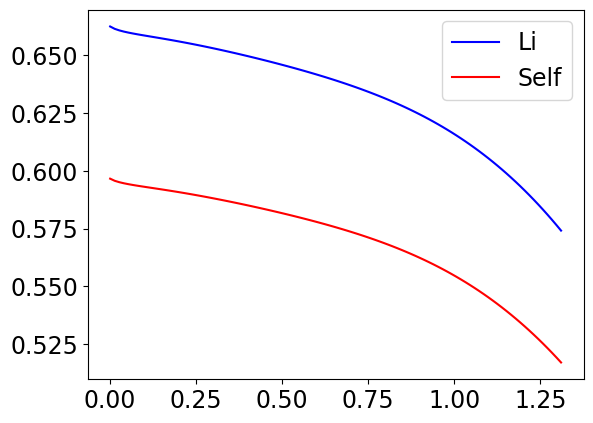

In [24]:
plt.plot(m_e_List,a_EMC_Li,'b',label="Li")
plt.plot(m_e_List,a_EMC_Self,'r',label="Self")
plt.legend()

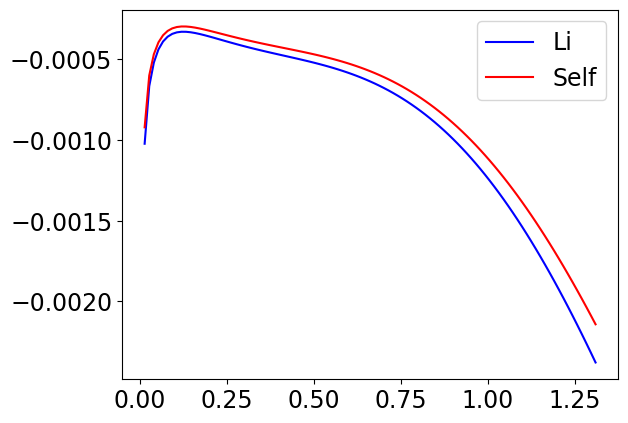

In [25]:
plt.plot(m_e_List[1:],np.diff(a_EMC_Li),'b',label="Li")
plt.plot(m_e_List[1:],np.diff(a_EMC_Self),'r',label="Self")
plt.legend()